# Emulation of air quality in China

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeconibear/emulator_training/blob/main/emulator_training.ipynb)

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

![emulator.png](https://user-images.githubusercontent.com/19871268/128219782-a93b83a1-eafa-4e06-851e-92b4e10c256b.png)

Images [1](https://www.nasa.gov/content/a-portrait-of-global-winds/), [2](https://www.aidanscannell.com/post/gaussian-process-regression/), and [3](http://6degreesoffreedom.co/circle-random-sampling/).  

## Approach

### Problem
1. Identify
    - What is the problem you're trying to solve?
2. Inputs
    - What inputs go into the emulator?
3. Outputs
    - What will the emulator predict?

### Simulations
4. Design
    - Determine what the simulations will be (taking account of the inputs above).  
5. Run
    - Perform these simulations (including a control run).  
6. Evaluate
    - Compare the control simulation to measurements to ensure accurately represents the outputs above.

### Emulators
7. Design
    - Optimise the design of the emulators.  
8. Training
    - Train the emulators on the simulation data.
9. Evaluate
    - Test the emulators on the held-out test data.
10. Predict
    - Use the emulators for new predictions.

## Case study

### 1. Problem: Identify

Predict air quality from emission changes.  

### 2. Problem: Inputs

5 inputs, key anthropogenic emission sectors:  
- Residential (RES)
- Industrial (IND)
- Land transport (TRA)
- Agriculture (AGR)
- Power generation (ENE)

In [186]:
sectors = ['RES', 'IND', 'TRA', 'AGR', 'ENE']

### 3. Problem: Outputs

1 output: PM$_{2.5}$ concentrations.  

In [185]:
output = 'PM2_5_DRY'

### 4. Simulations: Design

Maximin [Latin-hypercube design](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) using [pyDOE's](https://pythonhosted.org/pyDOE/index.html) [`lhs`](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube-lhs) method.
- For training, the number of simulation runs required is 10 times the number of inputs to adequately cover the parameter space (e.g., for 5 inputs, you'll need 50 runs).  
- For testing, have a separate set of simulations. A smaller number will suffice (e.g., for 5 inputs, 5 test simulations).  
- Near-random sample of values across the whole parameter space.  
- Maxi-min: Decide on a maximum and minimum value for the inputs, defaults to 1.0 and 0.0.  
- Choose number of iterations for the sampling (100,000 is common, though using 1,000 here is the example to run faster).  

In [ ]:
if IN_COLAB:
    !pip install --upgrade pyDOE

In [21]:
import pandas as pd
from pyDOE import lhs
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
number_inputs = 5
iterations = 1_000 # use 100_000 in actual work

# create latin hypercube design, sampled between 0 (min) and 1 (max)
design_train = lhs(
    number_inputs, 
    samples=number_inputs * 10, 
    criterion='maximin', 
    iterations=iterations)

design_test = lhs(
    number_inputs, 
    samples=number_inputs, 
    criterion='maximin', 
    iterations=iterations)

# change scaling of max/min if appropriate
max_value = 1.5 # scale inputs up to 150% of baseline

design_train = design_train * max_value
design_test = design_test * max_value

In [64]:
# convert numpy arrays to pandas dataframes
inputs_train = pd.DataFrame(data=design_train, columns=sectors)
inputs_test = pd.DataFrame(data=design_test, columns=sectors)

In [65]:
inputs_train.describe()

,RES,IND,TRA,AGR,ENE
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.749161,0.750940,0.749607,0.750738,0.749956
std,0.438166,0.435452,0.436720,0.436484,0.438847
min,0.002469,0.023967,0.025962,0.017563,0.007330
25%,0.389154,0.376189,0.392263,0.379415,0.386675
50%,0.751334,0.742579,0.755435,0.754280,0.747275
75%,1.123460,1.111922,1.114818,1.114001,1.108076
max,1.487578,1.477022,1.477576,1.478221,1.491858


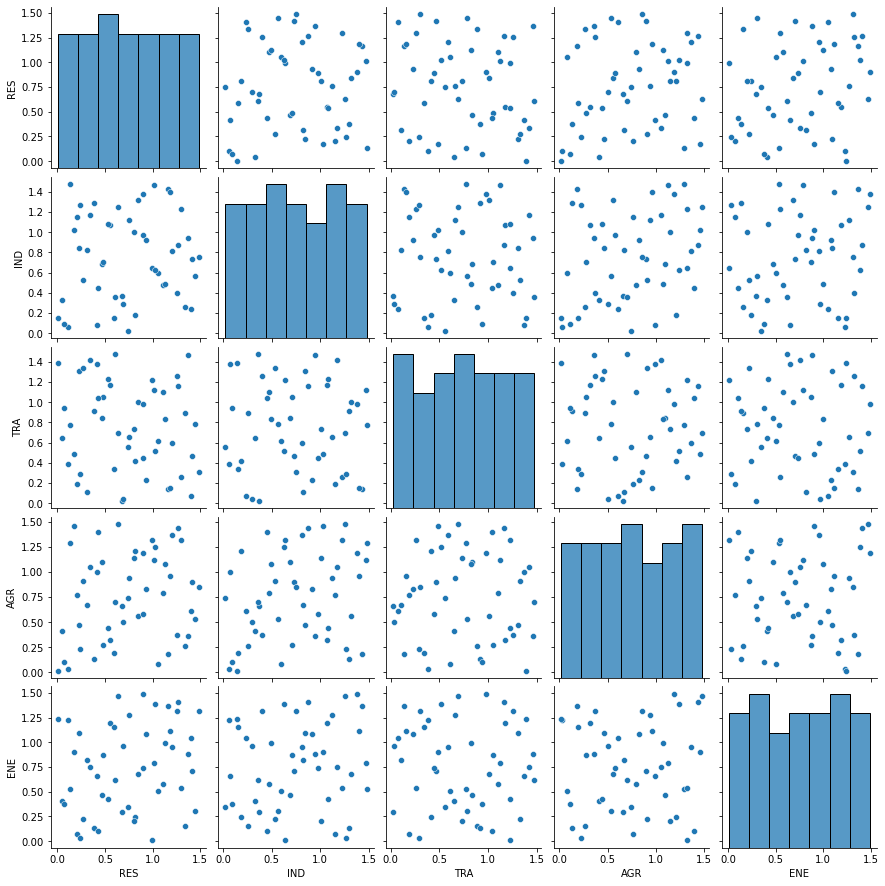

In [66]:
# plot the pairs as a histogram to check random sample over parameter space
sns.pairplot(inputs_train, diag_kind='hist')
plt.show()

In [ ]:
if IN_COLAB:
    !wget https://raw.githubusercontent.com/lukeconibear/emulator_training/main/latin_hypercube_inputs_train.csv
    !wget https://raw.githubusercontent.com/lukeconibear/emulator_training/main/latin_hypercube_inputs_test.csv

In [423]:
# read in actual ones used
inputs_train = pd.read_csv('latin_hypercube_inputs_train.csv')
inputs_test = pd.read_csv('latin_hypercube_inputs_test.csv')

In [424]:
# convert to arrays
X_train, X_test = inputs_train.values, inputs_test.values

### 5. Simulations: Run

Use a complex air quality model ([WRFChem](https://wrfchem-leeds.github.io/WRFotron/)).  
- 50 years of training simulations.  
- 5 years of testing simulations.  
- 1 year for the control simulation.  

*Warning: this takes a long time, even on a [high-performance computer](https://arcdocs.leeds.ac.uk/welcome.html).*

In [ ]:
if IN_COLAB:
    !wget https://raw.githubusercontent.com/lukeconibear/emulator_training/main/df_train.csv
    !wget https://raw.githubusercontent.com/lukeconibear/emulator_training/main/df_test.csv

In [129]:
df_train = pd.read_csv('df_train.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('df_test.csv', index_col='Unnamed: 0')

In [134]:
df_train.describe()

,lat,lon,PM2_5_DRY
count,763900.000000,763900.000000,763900.000000
mean,36.393703,103.816550,26.587433
std,7.174413,14.381102,22.442314
min,18.250000,73.750000,4.906912
25%,31.000000,91.250000,11.606082
50%,36.500000,104.750000,17.319699
75%,41.750000,115.750000,33.995969
max,53.250000,134.500000,180.305663


In [305]:
gridcells = df_train[['lat', 'lon']].drop_duplicates().values.tolist()

print(f'There are {len(gridcells)} grid cells in the domain.')

There are 15278 grid cells in the domain.


In [306]:
# pick a random grid cell (no reproducible seed, lucky dip!)
import random

random_gridcell_lat, random_gridcell_lon = random.choice(gridcells)

In [411]:
# lets see what you picked ...
print(f'Lat = {random_gridcell_lat}')
print(f'Lon = {random_gridcell_lon}')

Lat = 36.25
Lon = 101.25


In [410]:
# output for 

random_gridcell_y_train = df_train.loc[df_train.lat == random_gridcell_lat].loc[df_train.lon == random_gridcell_lon][[output]].values
random_gridcell_y_test = df_test.loc[df_test.lat == random_gridcell_lat].loc[df_test.lon == random_gridcell_lon][[output]].values

random_gridcell_y_train

array([[11.25783996],
       [19.1375564 ],
       [16.50302699],
       [18.36644343],
       [15.64524382],
       [18.44202067],
       [17.01299307],
       [14.7966861 ],
       [15.22066507],
       [16.34073539],
       [14.7404012 ],
       [16.41348505],
       [19.94289739],
       [15.13606447],
       [14.780315  ],
       [14.11928433],
       [18.22491677],
       [15.76506092],
       [13.38877843],
       [13.58062386],
       [16.28242607],
       [19.70962642],
       [13.72079868],
       [13.20343779],
       [15.31079062],
       [15.56811214],
       [14.07423371],
       [19.6386412 ],
       [14.96942271],
       [10.87399813],
       [13.19465483],
       [11.06842817],
       [15.12886535],
       [16.27218461],
       [12.92226409],
       [13.18218928],
       [19.24891698],
       [13.80747604],
       [16.2235145 ],
       [13.16871895],
       [16.30549097],
       [13.78906511],
       [14.92721292],
       [14.10567161],
       [13.75040662],
       [13

### 6. Simulations: Evaluate

Evaluate it against measurements to ensure it accurately predicts outputs.  

### 7. Emulators: Design

We optimised the design and hyperparameters of the model using genetic programming (automatic machine learning tool, [TPOT](http://epistasislab.github.io/tpot/)).  

Our final design included:
- Gaussian process regressors are implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html?highlight=gaussian%20process#sklearn.gaussian_process.GaussianProcessRegressor).  
- Preprocessing the inputs with a power transform ([Yeo-Johnson](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)) to make them more Gaussian-like.  
- We used a [Matern](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html?highlight=matern#sklearn.gaussian_process.kernels.Matern) kernel.  

In [412]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [413]:
emulator = make_pipeline(
    PowerTransformer(),
    GaussianProcessRegressor(
        kernel=Matern(length_scale=3.4, nu=2.5), 
        n_restarts_optimizer=240, 
        normalize_y=False)
)
emulator

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(kernel=Matern(length_scale=3.4, nu=2.5),
                                          n_restarts_optimizer=240))])

### 8. Emulators: Training

The emulators were trained on the 50 years of simulator data (in parallel on a high-performance computer).  
Example below for the single random grid cell.

In [414]:
emulator.fit(X_train, random_gridcell_y_train)

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(kernel=Matern(length_scale=3.4, nu=2.5),
                                          n_restarts_optimizer=240))])

### 9. Emulators: Evaluate

Predict unseen test data and evaluate against simulated values.

In [415]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [416]:
def root_mean_squared_error(y_true, y_pred):
    return np.round(np.sqrt(np.abs(mean_squared_error(y_true, y_pred))), decimals=4)

def coefficient_of_determination(y_true, y_pred):
    return np.round(r2_score(y_true, y_pred), decimals=4)

In [417]:
def create_scatter_plot(lat, lon, output, label, y_test, y_pred, rmse_test, r2_test):
    fig = plt.figure(1, figsize=(5, 5))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0])
    ax.set_facecolor('whitesmoke')
    plt.title(f'Random grid cell\n(lat = {lat}, lon = {lon})', fontsize=14)
    
    limit = int(np.ceil(np.nanmax(random_gridcell_y_pred) / 5)) * 5
    plt.xlim([0, limit])
    plt.ylim([0, limit])
    
    ticks = np.linspace(0, 20, limit // int(limit / 5))
    plt.xticks(ticks, fontsize=14)
    plt.yticks(ticks, fontsize=14)
    plt.xlabel('Simulator, ' + label, fontsize=14)
    plt.ylabel('Emulator, ' + label, fontsize=14)
    
    plt.scatter(np.vstack(y_test), np.vstack(y_pred), s=50)
    
    x = np.arange(2 * np.ceil(limit))
    plt.plot(x, x, color='grey', linestyle='--')
    plt.plot(x, 0.5 * x, color='grey', linestyle='--')
    plt.plot(x, 2 * x, color='grey', linestyle='--')
    
    text = "R$^2$ = " + str(r2_test) + "\nRMSE = " + str(rmse_test)
    at = matplotlib.offsetbox.AnchoredText(text, prop=dict(size=14), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

In [418]:
random_gridcell_y_pred = emulator.predict(X_test)
random_gridcell_y_pred

array([[13.37813162],
       [12.42146203],
       [19.99734164],
       [15.70021713],
       [15.63806688]])

In [419]:
random_gridcell_rmse_test = root_mean_squared_error(random_gridcell_y_test, random_gridcell_y_pred)
random_gridcell_r2_test = coefficient_of_determination(random_gridcell_y_test, random_gridcell_y_pred)

print(f'The random grid cell has a RSME value of: {random_gridcell_rmse_test} ugm-3')
print(f'The random grid cell has a R^2 value of:  {random_gridcell_r2_test}')

The random grid cell has a RSME value of: 0.1407 ugm-3
The random grid cell has a R^2 value of:  0.9969


In [383]:
label = 'annual-mean PM$_{2.5}$\nconcentrations (${\mu}g$ $m^{-3}$)'

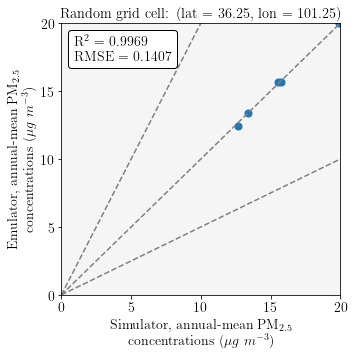

In [384]:
# example for the random grid cell
create_scatter_plot(
    random_gridcell_lat,
    random_gridcell_lon,
    output, 
    label, 
    random_gridcell_y_test, 
    random_gridcell_y_pred, 
    random_gridcell_rmse_test,
    random_gridcell_r2_test)

We developed 1 emulator per grid cell from the simulator (15,278 grid cells) to capture the spatial distribution of the output.

### 10. Emulators: Predict

All 15,278 emulators were then used to predict air quality concentrations for all emission configurations within a 0−150% matrix of emission scaling factors at 20% increments (32,768 emission configurations).

In [430]:
from IPython.display import IFrame

In [433]:
IFrame("https://emulator.pythonanywhere.com/", width=800, height=800)

## Further information
- Short-term air quality prediction.
    - [Code](https://github.com/lukeconibear/emulator).
    - Papers:
        - *Conibear, L. Reddington, C. L., Silver, B. J., Chen, Y., Knote, C., Arnold, S. R., Spracklen, D. V. (2021). Statistical emulation of winter ambient fine particulate matter concentrations from emission changes in China, GeoHealth, [DOI](https://doi.org/10.1029/2021GH000391).*
- Long-term air quality and public health prediction
    - [Code](https://github.com/lukeconibear/emulator_annual).
    - Papers:
        - *Conibear, L. Reddington, C. L., Silver, B. J., Chen, Y., Knote, C., Arnold, S. R., Spracklen, D. V. (2021, in prep.). Machine Learning Emulation of Long−Term Air Pollution Exposure and Disease Burden from Emission Changes in China.*
        - *Conibear, L. Reddington, C. L., Silver, B. J., Arnold, S. R., Turnock, S. T., Klimont, Z., Spracklen, D. V. (2021, in prep.). The Contribution of Emission Sources to the Future Air Pollution Disease Burden in China.*
        - *Conibear, L. Reddington, C. L., Silver, B. J., Chen, Y., Knote, C., Arnold, S. R., Spracklen, D. V. (2021, in prep.). Emission Sector Impacts on Air Quality and Public Health in China from 2010−2020.*